In [10]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import seaborn as sns
import utils
import importlib
sns.set()

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.5.1  Device: cuda


In [8]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


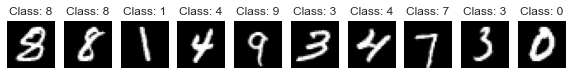

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i].item()))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [6]:
def train(epoch, log_interval=200):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad() 
        
        output = model(data)

        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [7]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] 
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [8]:
%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329518
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.160527
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.576880
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.959098
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.684569
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.223702
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.519606
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.849140
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.495779
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.310991

Validation set: Average loss: 0.3572, Accuracy: 8990/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.360688
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.402951
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.884426
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.265284
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.535313
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.487233
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.351574
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.716708
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.54

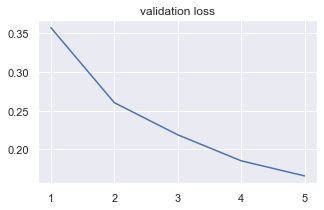

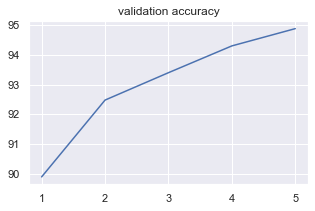

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

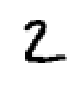

In [28]:
img, val = validation_dataset[1]
imgs = img.numpy().reshape(28,28)[np.newaxis, np.newaxis, :, :]

importlib.reload(utils)
utils.plot_mnist(imgs, [1,1])
img = img.to(device)

In [7]:
outputs = model(img)
print(outputs)

_, predicted = torch.max(outputs, 1)

print(f'Predicted: {predicted.cpu().numpy()}')

NameError: name 'img' is not defined

torch.Size([32, 1, 28, 28])


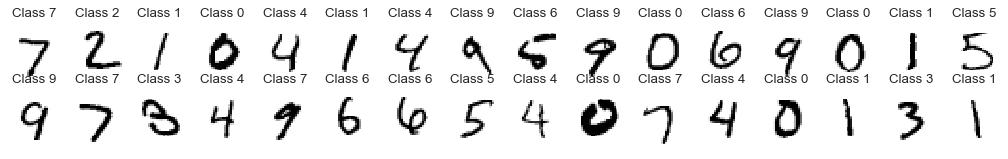

In [29]:
#тут сразу батч будет - 32 штуки
dataiter = iter(validation_loader)
img, label = dataiter.next()

outputs = model(img.to(device))
_, predicted = torch.max(outputs, 1)

print(img.size())
utils.plot_mnist(img, [2, 16], list(predicted.cpu().numpy()))

In [25]:
print(list(predicted.cpu().numpy()))
print(type(list(predicted.cpu().numpy())))

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1]
<class 'list'>


In [46]:
import pathlib
pathlib.Path('./models').mkdir(parents=True, exist_ok=True)
PATH = './models/mnist1.pth'

torch.save(model.state_dict(), PATH)


In [19]:
PATH = './models/mnist1.pth'
model = Net().to(device)
model.load_state_dict(torch.load(PATH, map_location=device))


<All keys matched successfully>